In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# For warnings
import warnings
warnings.filterwarnings('ignore')

# Import the monitoring scripts
import sys
sys.path.insert(0, '../../src/models')

from reports_monitoring import *

%matplotlib inline

In [2]:
store = pd.HDFStore('../../data/processed/orbf_benin.h5')
data_orbf = store['data']
store.close()

report_payment_data = data_orbf.groupby(['entity_id' , 'date']).apply(aggregate_data_payment)
report_payment_data['difference_amount'] = report_payment_data.claimed_payment - report_payment_data.verified_payment
report_payment_data['ratio'] = report_payment_data.claimed_payment  / report_payment_data.verified_payment 

## Some terminology

To differentiate the different types of data that are being handled in the analysis, we will use the following taxonomy :

1. __Claimed data__ is the data sent by the facilities, before any level of verification happens.
2. __Verified data__ is the data verified by OpenRBF teams during supervisions
3. __Validated data__ is the data on which the payment is finally based. This can be the original claimed data, if no verification was made, or it could be the verified data, if a verification was made.

## What are we monitoring ?

### Data quality

Data quality is an essential element of RBF. Building the trust that the data communicated by facilities reflects the demonstrable results of these facilities is essential to involving funders and other stakeholders in an RBF project.

There are two detrimental situations of bad data quality :
* __Over reporting__ when the claimed reports are excessively important and do in no way reflect the activity in the facility
* __Under reporting__ when claimed payments are way below the actual costs of the facility. In this situation, facilities will come to detrimental situations where they will be underfunded, which could affect their ability to provide proper services in the following months.


### Service conformity

Data on services also provides a picture of the activities that are carried out in a facility. As such, they allow to check if a facility is really providing the services it should be providing.


## Definition of _out of control_ situations

We want to track situations where the data reported by the facilities are considered _out of control_, i.e situations where facilities report data that are not consistent with past reported data, or with situations in other facilities.

To Identify these situations, we have to 
1. Define _in control_ situation based on available data
2. Define a variation threshold above which we consider the situation to be _out of control_
3. Test the incoming data based on these

In the OpenRBF situation, an definitions for the threshold can be based on different aspects :
1. % of variation of indicators from their expected value
2. % of variation of payment from their expected value
3. difference between expected and actual payment, and comparison to the cost of supervision

Based on the available data, I will for now define two thresholds :
1. The difference between the expected payment for the facility and the claimed payment should not exceed the supervision cost
2. The claimed payment should not be less than half the expected payment

The mean monthly supervision cost based on data from Bluesquare appears to be 170 000 CFA Francs. 

In [3]:
mean_supervision_cost = 170000
underfunding_max_risk = 0.5

In [4]:
report_payment_data['over_declaration'] = report_payment_data['difference_amount'] > mean_supervision_cost
report_payment_data['under_declaration'] = report_payment_data['ratio'] < underfunding_max_risk

## Data Quality Description

In [5]:
out_sup = sum(report_payment_data.over_declaration) / len(report_payment_data)
out_inf = sum(report_payment_data.under_declaration)  / len(report_payment_data)

print('Over declaration :' + str(out_sup))
print('Under declaration :' + str(out_inf))

n_facilities = len(report_payment_data.index.levels[0])

n_over_fac = report_payment_data[report_payment_data.over_declaration].reset_index().entity_id.nunique() / n_facilities
n_under_fac = report_payment_data[report_payment_data.under_declaration].reset_index().entity_id.nunique() / n_facilities
print('Overdeclaring Facilities :' + str(n_over_fac))
print('Undedeclaring Facilities :' + str(n_under_fac))

Over declaration :0.0842477217779
Under declaration :0.00495939495382
Overdeclaring Facilities :0.45901639344262296
Undedeclaring Facilities :0.06557377049180328


Based on the validated data, we see that 9.6% of the reports were claiming excessive amounts that were over the cost of verification, while 0.5% of the reports were claiming amounts that would have resulted in an undefunding of the facilities activities. 

47% of the facilities reported did an _ooc_ overestimation at least once, and 6.7% did an _ooc_ underestimation at least once in the data.

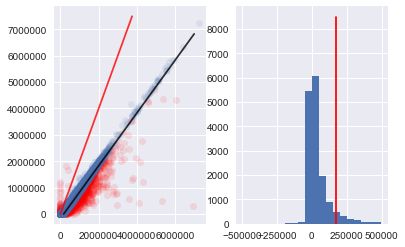

In [6]:
plotting_data = report_payment_data[(report_payment_data['claimed_payment'] < 10000000)]

outliers = plotting_data[plotting_data['over_declaration'] | plotting_data['under_declaration']]
in_control = plotting_data[~ (plotting_data['over_declaration']) & ~(plotting_data['under_declaration'])]

plt.figure(1)
plt.subplot(1,2,1)
plt.plot( outliers.claimed_payment , outliers.verified_payment , 'ro', alpha = 0.1)
plt.plot( in_control.claimed_payment , in_control.verified_payment , 'o' , alpha = 0.1)
plt.plot((0,3750000) , (0,7500000) , 'r-' , alpha = 0.8)
plt.plot((mean_supervision_cost,7000000) , (0,(7000000 - mean_supervision_cost)) , 'k-' , alpha = 0.8)
plotting_data = plotting_data[np.abs(plotting_data['difference_amount']) < 500000]
plt.subplot(1,2,2)
plt.hist(plotting_data[:]['difference_amount'] , bins = 20 )
plt.plot((mean_supervision_cost, mean_supervision_cost), (0, 8500), 'r-')

Graph XX shows the distribution of the data we want to spot. Red data dots are outside of the zone in which we want the data to be. Reports under the black line were overreporting, and reports over the red line were underreporting too strongly before data validation.

## Supervision Costs

In [7]:
data_orbf.entity_id.nunique() * mean_supervision_cost / ((sum(report_payment_data.verified_payment) / 12) + data_orbf.entity_id.nunique() * mean_supervision_cost)

0.12591685239359085

We see that in the current supervision regime, costs of supervision represent 12 % of the overall program. This is an important cost, especially considering that 92% of the supervisions are more costly than the corresponding reduction in payment.

The process of data verification is thus costly and time consuming for public health authorities. The aim of this project is ot orient these efforts of supervision to maximize the chance of identifying data issues or services problems.

## Methods

### A classification problem

Based on this first presentation, we want to classify all incoming data in four categories :
1. __In control__ : will be for all the data that seems to follow expected distributions and evolutions
2. __Data Issue__ : will be for data with unexpected values, that can be linked to data quality issues. This includes :
    1. __Overestimation__ : will screen and spot the data that seems to be overshooting the expected values by too wide a margin, as previously defined
    2. __Underestimation__ : will screen and spot the data that seems to be underevaluating the expected payments by a too wide factor
4. __Quality issue__ : finally, we will aim at identifying reports that seem to show issues in the quality of care in the facility

### Building classification features

To do this classification, we will build features, characterizing the place of the observed values in the expected distributions. We will test 3 approaches to build these features.

The features will need to be built on different dimensions :
1. Internal consistency of each serie : surveillance
2. Facility consistency with other facilities : hierarchical
3. Profile consistency for the facility / Profile consistency with other facilities

## Surveillance approach

In an Surveillance approach, we will want to monitor the amounts paid to a facility on a monthly basis, and spot a divergence from the expected _in control_ distribution. Methods for this are from a CUSUM family, and use control charts as output to present and interpret the results.

Essentially, in this approach, we want to check if any of the individual observed series in the reports are showing unexpected patterns. To do this, for each facility I will :
1. Model each report serie using an ARIMA based on historic data
2. Get a prediction for the new data
3. Compared the new data to the distribution of expected data 

## Hierarchical modelling

A second approach is to model the values we should observe for different indicators, using 

## Profile monitoring

Finally, we want to check intern consistency of reports. This consistency should be the defined both within facilties and among facilites.

## Classification

## Verification strategies testing

### Different strategies

### Strategy 1 : Complete Supervision

In [8]:
fac_data = data_orbf[data_orbf.entity_id == 180]    
    
### Building the training set :
perc_train = 0.2
TS = create_facility_training_dict(fac_data , perc_train)

test_data = fac_data[~(fac_data.date.isin(TS['train_months']))]
n_periods = test_data.reset_index()['date'].nunique()
strat_1_cost = summary_cost(sum(test_data.indicator_montant) , mean_supervision_cost*n_periods)
print(strat_1_cost)

{'perc_supervision': 0.18476387214191842, 'payments': 33004105.0, 'total_cost': 40484105.0}


### Strategy 2 : Supervision every Cost alerts only

TEMP : Building this functions : what does what

* __TS :__ Keeping track of the training set
* __dict :__ to create, dictionnary with useful indicator info such as tarif, group, ...
* __models :__having methods for running the model / raising alarm etc...
* __out :__ one by model, will keep all the useful outputs by model
* __additional methods :__ for aggregating / displaying the results

In [9]:
tarifs = []

for i in data_orbf.indicator_label.unique() :
    tarifs.append(data_orbf.indicator_tarif[data_orbf.indicator_label == i].tolist()[0])
    
tarifs = pd.Series(tarifs , index = data_orbf.indicator_label.unique())

In [10]:
def make_full_path(fac_data , perc_train , tarifs , mean_supervision_cost , underfunding_max_risk):
    import sys
    sys.path.insert(0, 'c://users/grlurton/documents/orbf_data_quality/src/models')
    import reports_monitoring
    facility_id = fac_data.entity_id.unique()[0]
    TS = reports_monitoring.create_facility_training_dict(fac_data , perc_train)
    test_data = fac_data[~(fac_data.date.isin(TS['train_months']))]
    out = {}
    out[facility_id] = {}
    for month in test_data['date'].sort_values().unique():
        ## Initiating the function parameters and output
        dat_month = fac_data[fac_data.date == month].set_index('indicator_label')
    
        ## Screening the data
        arima_screened = reports_monitoring.arima_report_payment(dat_month , TS)
    
        ## Checking Alarm
        BLIP = reports_monitoring.overcost_alarm(dat_month.indicator_claimed_value , arima_screened['expected_values'] , tarifs ,
                              mean_supervision_cost , underfunding_max_risk)

        ## Updating the data
        payment_made = reports_monitoring.make_training_set(TS , dat_month , BLIP)
    
        ## Make the output
        month_char = str(month)[0:7]
        out[facility_id][month_char] = reports_monitoring.make_output(dat_month , arima_screened['expected_values'] , 
                                                                      payment_made , BLIP)

    collapsed_output = reports_monitoring.collapse_output(out , tarifs)
    return collapsed_output

In [11]:
import ipyparallel

clients = ipyparallel.Client()
clients.ids

dview = clients[:]

In [12]:
data_run = data_orbf.iloc[0:1000]

def run(data , make_full_path = make_full_path , tarifs = tarifs ,
                              mean_supervision_cost = mean_supervision_cost, underfunding_max_risk = mean_supervision_cost):
    result = make_full_path(data , 0.2 , tarifs , mean_supervision_cost  , underfunding_max_risk)
    return result

In [13]:
%%time
fac = []
for fac_id in data_orbf.entity_id.unique():
    fac_data = data_orbf[data_orbf.entity_id == fac_id]
    fac.append(fac_data)

Wall time: 5.83 s


In [ ]:
%%time

result = dview.map_sync(run , fac)

In [ ]:
out = result.get()

In [ ]:
pd.DataFrame(out[0])

In [ ]:
costs = []
supervision = []
total_cost=  []
for fac in full_out.keys():
    summary_pay = summary_cost(full_out[fac]['validated'] , mean_supervision_cost*sum(full_out[fac]['alarms']))
    costs.append(sum(summary_pay['payments']))
    supervision.append(sum(summary_pay['total_cost'] - summary_pay['payments']))
    total_cost.append(sum(summary_pay['total_cost']))
    
out = pd.DataFrame({'costs':costs , 'supervision':supervision ,  'total_cost':total_cost})

In [ ]:
out = out.sort_values('total_cost')

In [ ]:
out[['costs' , 'supervision']].plot.bar(stacked = True)

In [ ]:
out['perc_supervision'] = out.supervision / (out.supervision + out.costs)
out.loc[(np.isinf(np.abs(out['perc_supervision']))) | np.isnan(out['perc_supervision']) ,   'perc_supervision'] = 0
max(out.perc_supervision)
sum(np.isinf(out.supervision))

In [ ]:
dat_month.entity_id.unique()[0]

In [ ]:
plt.hist(out.perc_supervision)

In [ ]:
plot_monitoring(full_out[23])

In [ ]:
len(full_out[670]['alarms'])

In [ ]:
strat_2_cost = summary_cost(sum(collapsed_output['validated']) , mean_supervision_cost*sum(collapsed_output['alarms']))
print(strat_2_cost)
print(sum(collapsed_output['alarms']) / len(collapsed_output['alarms']))
perc_months_supervisions2 = sum(collapsed_output['alarms']) / len(collapsed_output['alarms'])

per_overcost_prevented2 = perc_overvcost_prevented(collapsed_output)
print(per_overcost_prevented2)


def perc_undercost_prevented(outcome):
    ovp = sum((pd.Series(outcome['claimed']) / pd.Series(outcome['validated']) < .5)) /  sum((pd.Series(outcome['claimed']) / pd.Series(outcome['verified']) < .5))
    if np.isnan(ovp) :
        ovp = 1
    return ovp
perc_undercost_prevented2 = perc_undercost_prevented(collapsed_output)
print(perc_undercost_prevented(collapsed_output))


def perc_false_alarms(outcome):
    n_alarms = sum(pd.Series(collapsed_output['alarms']))
    fa = pd.Series(collapsed_output['claimed'])[pd.Series(collapsed_output['alarms'])] - pd.Series(collapsed_output['validated'])[pd.Series(collapsed_output['alarms'])] <  mean_supervision_cost
    far = sum(fa) / n_alarms
    return far
perc_false_alarms2 = perc_false_alarms(collapsed_output)
print(perc_false_alarms(collapsed_output))

### Strategy 3 : Supervision for multiple diverging performances

In [ ]:
fac = 23 
fac_data = data_orbf[(data_orbf.entity_id == fac)]
perc_train = 0.2

### Building the training set :
TS = create_facility_training_dict(fac_data , perc_train)
out = {}

In [ ]:
out

In [ ]:
for month in test_data['date'].sort_values().unique():
    ## Initiating the function parameters and output
    dat_month = fac_data[fac_data.date == month].set_index('indicator_label')
    
    ## Screening the data
    arima_screened = arima_report_payment(dat_month , TS)
    
    z_score = np.abs(dat_month.indicator_claimed_value - arima_screened['expected_values']) / arima_screened['std_vals']
    BLIP = np.nansum(z_score > 2) > 2
    
    ## Updating the data
    payment_made = make_training_set(TS , dat_month , BLIP)
    
    ## Make the output
    month_char = str(month)[0:7]
    out[month_char] = make_output(dat_month , arima_screened['expected_values'] , payment_made , BLIP)

    
collapsed_output = collapse_output(out , tarifs)
plot_monitoring(collapsed_output)

In [ ]:
strat_3_cost = summary_cost(sum(collapsed_output['validated']) , mean_supervision_cost*sum(collapsed_output['alarms']))
print(strat_3_cost)
print(sum(collapsed_output['alarms']) / len(collapsed_output['alarms']))

perc_months_supervisions3 = sum(collapsed_output['alarms']) / len(collapsed_output['alarms'])


def perc_overvcost_prevented(outcome):
    ovp = sum((pd.Series(outcome['claimed']) - pd.Series(outcome['validated']) > mean_supervision_cost)) /  sum((pd.Series(outcome['claimed']) - pd.Series(outcome['verified']) > mean_supervision_cost))
    return ovp
per_overcost_prevented3 = perc_overvcost_prevented(collapsed_output)
print(perc_overvcost_prevented(collapsed_output))


def perc_undercost_prevented(outcome):
    ovp = sum((pd.Series(outcome['claimed']) / pd.Series(outcome['validated']) < .5)) /  sum((pd.Series(outcome['claimed']) / pd.Series(outcome['verified']) < .5))
    if np.isnan(ovp) :
        ovp = 1
    return ovp
perc_undercost_prevented3 = perc_undercost_prevented(collapsed_output)
print(perc_undercost_prevented(collapsed_output))


def perc_false_alarms(outcome):
    n_alarms = sum(pd.Series(collapsed_output['alarms']))
    fa = pd.Series(collapsed_output['claimed'])[pd.Series(collapsed_output['alarms'])] - pd.Series(collapsed_output['validated'])[pd.Series(collapsed_output['alarms'])] <  mean_supervision_cost
    far = sum(fa) / n_alarms
    return far
perc_false_alarms3 = perc_false_alarms(collapsed_output)
print(perc_false_alarms(collapsed_output))

### Comparisons

In [ ]:
plt.plot(strat_1_cost['total_cost'] , strat_1_cost['perc_supervision'] , 'o')
plt.plot(strat_2_cost['total_cost'] , strat_2_cost['perc_supervision'] , 'o')
plt.plot(strat_3_cost['total_cost'] , strat_3_cost['perc_supervision'] , 'o')

In [ ]:
#from http://matplotlib.org/examples/api/radar_chart.html

"""
======================================
Radar chart (aka spider or star chart)
======================================

This example creates a radar chart, also known as a spider or star chart [1]_.

Although this example allows a frame of either 'circle' or 'polygon', polygon
frames don't have proper gridlines (the lines are circles instead of polygons).
It's possible to get a polygon grid by setting GRIDLINE_INTERPOLATION_STEPS in
matplotlib.axis to the desired number of vertices, but the orientation of the
polygon is not aligned with the radial axes.

.. [1] http://en.wikipedia.org/wiki/Radar_chart
"""
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    # rotate theta such that the first axis is at the top
    theta += np.pi/2

    def draw_poly_patch(self):
        verts = unit_poly_verts(theta)
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_patch(self):
        # unit circle centered on (0.5, 0.5)
        return plt.Circle((0.5, 0.5), 0.5)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_patch = patch_dict[frame]

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == 'circle':
                return PolarAxes._gen_axes_spines(self)
            # The following is a hack to get the spines (i.e. the axes frame)
            # to draw correctly for a polygon frame.

            # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
            spine_type = 'circle'
            verts = unit_poly_verts(theta)
            # close off polygon by repeating first vertex
            verts.append(verts[0])
            path = Path(verts)

            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}

    register_projection(RadarAxes)
    return theta


def unit_poly_verts(theta):
    """Return vertices of polygon for subplot axes.

    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    """
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts


dimensions = ['% reduction from normal cost', '% Verification', '% Supervision Months', 
         '% overcost Prevented', '% underfund Prevented', 'Mean Supervision net benefit', 
         '% useful supervision', '% false alarms']

def example_data():
    data = [
        dimensions ,
        ('Overall', [
            [0, strat_1_cost['perc_supervision'] , 1 , 1, 1, 0.06, 0.01, 0.00],
            [1- strat_2_cost['total_cost'] /strat_1_cost['total_cost'],  strat_2_cost['perc_supervision'], 
             perc_months_supervisions2, per_overcost_prevented2, perc_undercost_prevented2, 
             perc_false_alarms2, 0.01, 0.00],
            [1- strat_3_cost['total_cost'] / strat_1_cost['total_cost'], strat_3_cost['perc_supervision'] , 
             perc_months_supervisions3, per_overcost_prevented3 , perc_undercost_prevented3,
             perc_false_alarms3, 0.00, 0.00]]),
        ('M0-M12', [
            [1, strat_1_cost['perc_supervision'] , 1 , 1, 0.00, 0.06, 0.01, 0.00],
            [strat_2_cost['total_cost'] /strat_1_cost['total_cost'],  strat_2_cost['perc_supervision'], 
             perc_months_supervisions2, per_overcost_prevented2, 0.00, 0.02, 0.01, 0.00],
            [strat_3_cost['total_cost'] / strat_1_cost['total_cost'], strat_3_cost['perc_supervision'] , 
             perc_months_supervisions3, per_overcost_prevented3 , 0.05, 0.10, 0.00, 0.00]]),
        ('M12-M36', [
            [1, strat_1_cost['perc_supervision'] , 1 , 1, 0.00, 0.06, 0.01, 0.00],
            [strat_2_cost['total_cost'] /strat_1_cost['total_cost'],  strat_2_cost['perc_supervision'], 
             perc_months_supervisions2, per_overcost_prevented2, 0.00, 0.02, 0.01, 0.00],
            [strat_3_cost['total_cost'] / strat_1_cost['total_cost'], strat_3_cost['perc_supervision'] , 
             perc_months_supervisions3, per_overcost_prevented3 , 0.05, 0.10, 0.00, 0.00]]),
        ('> M36', [
            [1, strat_1_cost['perc_supervision'] , 1 , 1, 0.00, 0.06, 0.01, 0.00],
            [strat_2_cost['total_cost'] /strat_1_cost['total_cost'],  strat_2_cost['perc_supervision'], 
             perc_months_supervisions2, per_overcost_prevented2, 0.00, 0.02, 0.01, 0.00],
            [strat_3_cost['total_cost'] / strat_1_cost['total_cost'], strat_3_cost['perc_supervision'] , 
             perc_months_supervisions3, per_overcost_prevented3 , 0.05, 0.10, 0.00, 0.00]])
    ]
    return data


N = len(dimensions)

if __name__ == '__main__':
    N = N
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data.pop(0)

    fig, axes = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                             subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm', 'y']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axes.flatten(), data):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    ax = axes[0, 0]
    labels = ('Full Verification', 'Excess Cost', '2 diverging Z-scores', 'Factor 4', 'Factor 5')
    legend = ax.legend(labels, loc=(0.9, .95),
                       labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, 'Comparison of different supervision scenarios',
             horizontalalignment='center', color='black', weight='bold',
             size='large')
    plt.show()